# Amazon Music Recommender

## Overview

> In this project, I aim to develop a collaborative filtering recommendation system tailored for Amazon digital music. By leveraging user interactions with music items, such as ratings or purchase histories, the system will analyze patterns and similarities among users and items to generate personalized music recommendations. The project will involve preprocessing the Amazon digital music dataset, training various collaborative filtering models, and evaluating their performance using metrics such as accuracy and coverage. Ultimately, the goal is to deploy a robust recommendation system that enhances the user experience by providing relevant and personalized music suggestions based on their preferences and behaviors.


## Business Understanding

> In the dynamic landscape of digital music, platforms like Amazon face the perpetual challenge of enhancing user engagement and satisfaction. With an abundance of music choices available, users often struggle to discover content that resonates with their preferences. To address this, Amazon is implementing a collaborative and content based filtering recommendation system aimed at providing personalized music suggestions. This initiative serves the needs of both users, who seek streamlined music discovery experiences, and Amazon, which aims to boost user retention, loyalty, and ultimately, revenue. By leveraging user data to tailor recommendations, Amazon not only fosters a more enjoyable user experience but also potentially increases sales through enhanced engagement with relevant music content.

# Data Understanding

> The dataset, was pulled from a compiled dataset of Amazon.The data set can be found in [here](https://nijianmo.github.io/amazon/index.html).The data contains two zipped JSON files: the review and metadata. Due to the large size of the data, GitHub couldn't allow me to upload it here, but it can be found on the link I provided above.

> Given that the rating distribution is not normal, it could influence our recommendation system model. Hence, we'll generate a new normalized rating column by subtracting the average rating of each reviewID from the original rating.

In [1]:
#imports
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from surprise import Dataset, Reader, accuracy , KNNWithMeans
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, NormalPredictor , BaselineOnly

plt.style.use('fast')
%matplotlib inline

In [2]:
# Read the CSV file 'music_review.csv' from the './Data/' directory into a DataFrame named 'music_review2'
music_review2 = pd.read_csv('./Data/music_review.csv')

In [3]:
music_review2.asin.nunique()

456811

In [4]:
music_review2.reviewerID.nunique()

839565

In [5]:
music_review2.isna().sum()

Unnamed: 0     0
overall        0
reviewerID     0
asin           0
reviewText    77
dtype: int64

In [6]:
# Drop the 'Unnamed: 0' column from the DataFrame 'music_review2'
music_review2 = music_review2.drop('Unnamed: 0', axis=1)

In [7]:
music_review2.dropna(inplace=True)

grouby by asin and join review text 

In [8]:
music_review2.reviewerID.value_counts()

reviewerID
A3W4D8XOGLWUN5    1255
AQ4B80F0JSBNI      660
A1Q0BU32CVOLRA     638
A2WQY1B8ZS7QRZ     534
A2H3JURQZOHVMB     484
                  ... 
A2LZCQX4PYF0F2       1
A783IMVI42EOH        1
AR7NVP4CS7XRE        1
ABN887FO84AES        1
AMWSDABZWFRAT        1
Name: count, Length: 839525, dtype: int64

> Let's eliminate rows with a total review and asin(song) count of one, as they are unlikely to significantly impact our model.

In [9]:
# Count the occurrences of each reviewer ID
reviewer_counts = music_review2['reviewerID'].value_counts()

# Find reviewer IDs with count equals to 1
reviewer_ids_to_drop = reviewer_counts[reviewer_counts == 1].index

# Drop rows where reviewer ID is in the list of IDs to drop
music_review2 = music_review2[~music_review2['reviewerID'].isin(reviewer_ids_to_drop)]


In [10]:
music_review2.asin.value_counts()

asin
B00CZF8B68    1661
B00M8JCW3E     865
B00NPZI1ZS     767
B00BWGHIHY     762
B0092MKTL2     746
              ... 
B004JE0C0G       1
B004JE25TM       1
B004JEPQ52       1
B004JESO3I       1
B01HJ91IVY       1
Name: count, Length: 333623, dtype: int64

In [11]:
# Count the occurrences of each reviewer ID
asin_counts = music_review2['asin'].value_counts()

# Find reviewer IDs with count equals to 1
asin_to_drop = asin_counts[asin_counts == 1].index

# Drop rows where reviewer ID is in the list of IDs to drop
music_review2 = music_review2[~music_review2['reviewerID'].isin(reviewer_ids_to_drop)]

> Given that the rating distribution is not normal, it could influence our recommendation system model. Addressing the collaborative filtering aspect, the ratings exhibited a non-normal distribution. To mitigate bias, I subtracted the average rating given by each user to all items from each item rated by that user.

C:\Users\Windows-10\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


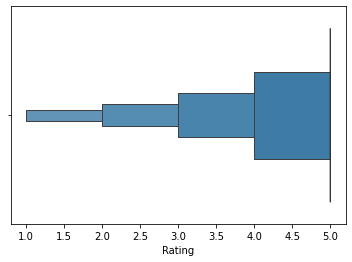

In [12]:
sns.boxenplot(music_review2.overall)
plt.xlabel('Rating')
plt.savefig('./Images/distribution_of_rating.png')

# Show the plot
plt.show()

>This code snippet performs data preprocessing steps to standardize the ratings in the 'overall' column of the 'music_review2' DataFrame. Firstly, the ratings are converted to integers to ensure consistency and facilitate further calculations. Next, the average rating for each reviewer is computed, providing a baseline for individual rating tendencies. By merging these average ratings back into the original DataFrame, reviewers' deviation from their typical rating behavior can be assessed. This deviation, represented by the 'normalized_rating' column, is calculated by subtracting each reviewer's average rating from their actual rating. The resulting 'normalized_rating' values range from approximately -3.97 to 3.89, indicating the extent of deviation from a reviewer's typical rating behavior. This preprocessing step helps mitigate biases arising from individual rating tendencies, ensuring a more equitable assessment of item ratings in subsequent analyses or recommendation systems.

In [13]:
# Convert 'overall' column to integers
music_review2['overall'] = music_review2['overall'].astype(int)

# Calculate average rating for each reviewer
reviewer_avg_ratings = music_review2.groupby('reviewerID')['overall'].mean().reset_index()

# Merge the average ratings back into the DataFrame
music_review2 = music_review2.merge(reviewer_avg_ratings, on='reviewerID', suffixes=('', '_avg'))

# Subtract average rating from each rating
music_review2['normalized_rating'] = music_review2['overall'] - music_review2['overall_avg']

In [14]:
# Display the minimum and maximum values of the 'normalized_rating' column in the DataFrame 'music_review2'
music_review2.normalized_rating.min(), music_review2.normalized_rating.max()

(-3.973140495867769, 3.891891891891892)

C:\Users\Windows-10\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


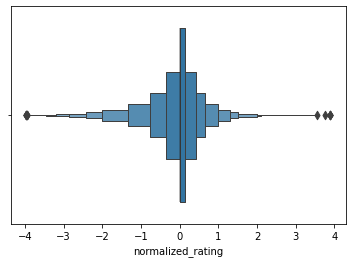

In [15]:
sns.boxenplot(music_review2.normalized_rating)
plt.savefig('./Images/distribution_of_normal_rating.png')
plt.show()

In [16]:
music_review2.shape

(894019, 6)

### Function for cross-validation

>The function calculate_average_rmse serves to assess the performance of a recommendation system model by computing the average Root Mean Squared Error (RMSE) through cross-validation. It takes two main inputs: the model itself and the dataset containing music review data. Utilizing the provided model and dataset, the function conducts cross-validation, which involves splitting the data into multiple subsets, training the model on some of these subsets, and evaluating its performance on the remaining ones. 

In [17]:
def calculate_average_rmse(model, music_review):
    # Perform cross-validation
    results = cross_validate(model, music_review, measures=['RMSE'], cv=3, n_jobs=-1, verbose=True)
    
    # Average RMSE
    average_rmse = round(sum(results["test_rmse"]) / len(results["test_rmse"]), 3)
    return average_rmse

### train test split using Surprise
> As the ratings have been normalized, the rating scale is now defined as (-3.973140495867769, 3.891891891891892).Load the music review dataset into the Surprise Dataset object, selecting columns 'reviewerID', 'asin', 'normalized_rating'. 

In [18]:
# Define the rating scale for the Reader object, specifying the minimum and maximum values
reader = Reader(rating_scale=(-3.973140495867769, 3.891891891891892))

# Load the music review dataset into the Surprise Dataset object, selecting specific columns
music_review = Dataset.load_from_df(music_review2[['reviewerID', 'asin', 'normalized_rating']], reader)

# Split the dataset into training and testing sets, with a test size of 20% and a fixed random state for reproducibility
trainset, testset = train_test_split(music_review, test_size=0.2, random_state=42)


### Simple Model

#### NormalPredictor

In [19]:
# Instantiate a NormalPredictor model
NP = NormalPredictor()

# Fit the NormalPredictor model on the training set
NP.fit(trainset)

# Generate predictions for the test set based on the model fit on the training set
predictions = NP.test(testset)

# Calculate the average RMSE using cross-validation for the NormalPredictor model
average_rmse_NP = calculate_average_rmse(NP, music_review)

# Print the average RMSE obtained from cross-validation
print(f'Average RMSE from cross-validation is : {average_rmse_NP}')

Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7878  0.7857  0.7876  0.7870  0.0010  
Fit time          0.85    0.78    0.66    0.76    0.08    
Test time         2.18    1.90    1.67    1.91    0.21    
Average RMSE from cross-validation is : 0.787


### SVD

In [20]:
# Create a basic SVD model with a specified random state
svd_basic = SVD(random_state=42)

# Fit the basic SVD model to the training set
svd_basic.fit(trainset)
predictions = svd_basic.test(testset)

# Calculate the RMSE for the predictions and store it in svd_simple
svd_simple = accuracy.rmse(predictions)

# Calculate the average RMSE across all folds using the calculate_average_rmse function
average_rmse_SVD1 = calculate_average_rmse(svd_basic, music_review)
print(f'Average RMSE from cross-validation is : {average_rmse_SVD1}')

RMSE: 0.5890
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5851  0.5841  0.5837  0.5843  0.0006  
Fit time          55.55   55.58   55.68   55.60   0.06    
Test time         3.58    3.19    2.80    3.19    0.32    
Average RMSE from cross-validation is : 0.584


##### svd_basic grid search

In [21]:
# Define a range of hyperparameters for GridSearchCV with SVD++
param_grid = {
    'n_factors': [50, 100, 150],  # Number of factors
    'n_epochs': [20, 30],  # Number of epochs
    'lr_all': [0.005, 0.01],  # Learning rate
    'reg_all': [0.02, 0.1]  # Regularization term
}

# Setup GridSearchCV with SVD++
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fit the model
gs_svd.fit(music_review)

# Best score and parameters
best_rmse = gs_svd.best_score['rmse']
best_params = gs_svd.best_params['rmse']

print(f"Best RMSE: {best_rmse}")
print(f"Best parameters: {best_params}")


Best RMSE: 1.0993641323939394

Best parameters: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.1}

In [22]:
# Define a more complex SVD model with specified parameters
SVD_2 = SVD(n_factors=50, n_epochs=30, lr_all=0.01, reg_all=0.1, random_state=42)

# Fit the more complex SVD model to the training set
SVD_2.fit(trainset)
predictions = SVD_2.test(testset)

# Calculate the RMSE for the predictions and store it in svd_simple
svd_simple = accuracy.rmse(predictions)

# Calculate the average RMSE across all folds using the calculate_average_rmse function
average_rmse_SVD2 = calculate_average_rmse(SVD_2, music_review)
print(f'Average RMSE from cross-validation is : {average_rmse_SVD2}')

RMSE: 0.6188
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.6130  0.6131  0.6110  0.6124  0.0010  
Fit time          52.20   52.75   53.05   52.67   0.35    
Test time         3.52    3.26    2.78    3.18    0.31    
Average RMSE from cross-validation is : 0.612


##### second SVD_3 gride search

In [23]:
# Setup new hyperparameter dictionary
svd_param_grid2 = {'n_factors':[5, 20],
                  'n_epochs': [20, 40], 
                  'lr_all': [0.05, .005],
                  'reg_all': [0.01, 0.02]}
svd_gr_3 = GridSearchCV(SVD,param_grid=svd_param_grid2,joblib_verbose=10, n_jobs=-1, cv=3)

# Return best_params based on RMSE
svd_gr_3 .fit(music_review)
svd_gr_3 .best_params['rmse']

{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}

In [24]:
# Define SVD model with specified parameters
SVD_3 = SVD(n_factors=5, n_epochs=20, lr_all=0.005, reg_all=0.02, random_state=42)

# Fit the SVD model to the training set
SVD_3.fit(trainset)
predictions = SVD_3.test(testset)

# Calculate the RMSE for the predictions and store it in svd_simple_3
svd_simple_3 = accuracy.rmse(predictions)

# Calculate the average RMSE across all folds using the calculate_average_rmse function
average_rmse_SVD3 = calculate_average_rmse(SVD_3, music_review)
print(f'Average RMSE from cross-validation is : {average_rmse_SVD3}')


RMSE: 0.5862
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.5792  0.5831  0.5840  0.5821  0.0021  
Fit time          16.49   16.79   16.50   16.59   0.14    
Test time         3.38    3.08    2.69    3.05    0.29    
Average RMSE from cross-validation is : 0.582


## SVD++

In [25]:
# Instantiate - fit on trainset - score the model on testset
SVDpp_basic= SVDpp(n_factors=1, n_epochs=25, random_state=42, reg_all=0.05)
SVDpp_basic.fit(trainset)
predictions = SVDpp_basic.test(testset)
SVDpp_gs = accuracy.rmse(predictions)

RMSE: 0.6033


#### SVDpp ++ gride search

In [26]:
param_grid = {'n_factors':[1, 5],
                    'n_epochs':[25, 50],
                    'reg_all':[0.02, 0.05]}

# Setup GridSearchCV with SVD++
gs_svdpp = GridSearchCV(SVDpp, param_grid, cv=3, joblib_verbose=10, n_jobs=-1, return_train_measures=True)


# Return best_params based on RMSE
gs_svdpp .fit(music_review)
gs_svdpp .best_params['rmse']

In [27]:
SVDpp_2= SVDpp(n_factors=5, n_epochs=25, random_state=42, reg_all=0.05)
SVDpp_2.fit(trainset)
predictions = SVDpp_2.test(testset)
SVDpp_2_gs = accuracy.rmse(predictions)

RMSE: 0.6031


## Model Evaluation

In [29]:
results = {
    'NormalPredictor': average_rmse_NP,
    'svd_basic': average_rmse_SVD1,
    'SVD_2 ': average_rmse_SVD2,
    'SVD_3':average_rmse_SVD3,
    'SVDpp_basic':SVDpp_gs,
    'SVDpp_2':SVDpp_2_gs, 
#     'co_clustering' : average_rmse_co_clustering,
}

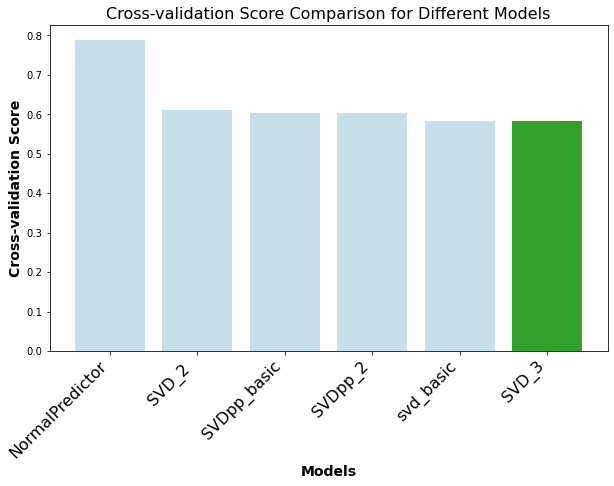

In [63]:
import matplotlib.pyplot as plt

# Sort results based on values
sorted_results = dict(sorted(results.items(), key=lambda item: item[1],reverse=True))

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#c7dfeb', '#c7dfeb', '#c7dfeb', '#c7dfeb', '#c7dfeb', '#33a02c']

plt.bar(sorted_results.keys(), sorted_results.values(), color=colors)

plt.xlabel('Models', fontsize=14 , fontweight='bold')
plt.ylabel('Cross-validation Score', fontsize=14 , fontweight='bold')
plt.title('Cross-validation Score Comparison for Different Models', fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=16)

plt.savefig('./Images/Model_evaluation.png')

# Show the plot
plt.show()

## Recommendation function 

#### pickle
> The SVD_3 model(The best model with RMSE of 0.58) is serialized and saved to a file named 'SVD.sav', allowing it to be loaded and reused later without needing to retrain the model. This is particularly useful for storing trained machine learning models for deployment or further analysis.

In [64]:
# Serialize and save the trained SVD_3 model to a file named 'SVD.sav'
pickle.dump(SVD_3, open('SVD.sav', 'wb'))

In [33]:
with open('SVD3.pkl', 'rb') as f:
    model = pickle.load(f)

The SVD_3 model is trained on the entire dataset, enabling it to learn from all available user-item interactions and generate predictions accordingly. Training on full train set is crucial for maximizing the model's performance by leveraging as much data as possible during the training process.


In [31]:
# Using Surprise, a full trainset incorporating all data can be built
trainset_full = music_review.build_full_trainset()

# Fit the SVD3 model to the full trainset to make full predictions
SVD_3.fit(trainset_full)


In [34]:
music_meta = pd.read_csv('./Data/music_meta.csv')
music_meta.drop(columns =['Unnamed: 0'], inplace=True)

In [35]:
music_meta.head()

,description,title,brand,asin,style
0,Unknown,Master Collection Volume One,John Michael Talbot,0001377647,Audio CD
1,Unknown,Hymns Collection: Hymns 1 &amp; 2,Second Chapter of Acts,0001529145,Audio CD
2,Unknown,Early Works - Don Francisco,Don Francisco,0001527134,Audio CD
3,Unknown,So You Wanna Go Back to Egypt,Keith Green,0001388703,Audio CD
4,"[""1. Losing Game 2. I Can't Wait 3. Didn't He ...",Early Works - Dallas Holm,Dallas Holm,0001526146,Audio CD


In [36]:
# Set the index of the DataFrame to 'reviewerID'
music_review_fun = music_review2.set_index('reviewerID')

# Drop columns that are not useful for modeling
music_review_fun.drop(columns=['overall', 'reviewText', 'overall_avg', 'normalized_rating'], inplace=True)

# Display the first few rows of the DataFrame
music_review_fun.head()


,asin
reviewerID,
A12R54MKO17TW0,0001388703
A12R54MKO17TW0,B000VZJS84
A12R54MKO17TW0,B000WLNUN6
A12R54MKO17TW0,B001232RGE
A12R54MKO17TW0,B00123KDR4


In [67]:
music_review_fun

,asin
reviewerID,
A12R54MKO17TW0,0001388703
A12R54MKO17TW0,B000VZJS84
A12R54MKO17TW0,B000WLNUN6
A12R54MKO17TW0,B001232RGE
A12R54MKO17TW0,B00123KDR4
...,...
A1J4OJHPYFOBBW,B01HIQQOGM
A2LKTPYFKMANMO,B01HIY9B00
A2LKTPYFKMANMO,B01HIY9DJ4


> The data frames music_review_fun and music_meta are exported to be utilized in the development of future applications.

In [55]:
# Assuming music_review_fun is your DataFrame
music_review_fun.to_csv("./Data/music_review_fun.csv" , index='reviewerID')

In [41]:
# Assuming music_review_fun is your DataFrame
music_meta.to_csv("./Data/music_meta.csv", index=False)

>The get_recommendations2 function aims to provide personalized recommendations for a given user based on their past reviews and predicted ratings. which  allows users to receive tailored recommendations based on their historical reviews and predicted preferences, thereby enhancing their overall experience with the music recommendation system.

In [39]:
def get_recommendations(user_id, num_recommendations):
    try:
        have_reviewed = list(music_review_fun.loc[user_id, 'asin'])
    except KeyError:
        return "User ID not found or user hasn't reviewed any items."

    not_reviewed = music_meta[~music_meta['asin'].isin(have_reviewed)].copy()
    not_reviewed.reset_index(inplace=True)

    if not_reviewed.empty:
        return "All items have been reviewed by the user."

    # Use loc to avoid SettingWithCopyWarning
    not_reviewed.loc[:, 'est_rating'] = not_reviewed['asin'].apply(lambda x: SVD_3.predict(user_id, x).est)
    not_reviewed.sort_values(by='est_rating', ascending=False, inplace=True)

    # Get top n recommendations
    recommendations = not_reviewed.head(num_recommendations)

    return recommendations

# Example usage:
user = input('UserId: ')
n_recs = int(input('How many recommendations? '))
recommendations = get_recommendations(user, n_recs)
recommendations

UserId: A12R54MKO17TW0
How many recommendations? 5


,index,description,title,brand,asin,style,est_rating
73134,73168,"[""This is a bundling of two remastered albums ...",Nirvana Nevermind and in Utero,Nirvana,B01BWT8CCU,MP3 Music,0.496395
64375,64409,"[""Who's Afraid of Virginia Woolf? (Original Br...",Who's Afraid of Virginia Woolf? Original Broad...,Original Broadway Cast of Who's Afraid of Virg...,B00J3CTVXI,MP3 Music,0.492120
60132,60166,['RECOPILACION DE SUS GRANDES EXITOS'],ANTOLOGIA MUSICAL (3 CD'S + DVD),Los Bukis,B00CFXXTK8,MP3 Music,0.464101
17774,17779,Unknown,Unsophisticated Time,Marti Jones,B0002BGOAM,MP3 Music,0.432342
9442,9445,Unknown,Unsophisticated Time,Marti Jones,B0002BGOAM,MP3 Music,0.432342


## Conclusion

> Throughout the development of the collaborative and content-based recommendation systems in this project, a multifaceted approach to data preprocessing was employed. Initially, in the collaborative filtering aspect, meticulous attention was devoted to understanding user behavior through thorough analysis of rating patterns. Leveraging collaborative filtering algorithms, such as Singular Value Decomposition (SVD), the system adeptly identified latent relationships among users and items, enabling the generation of personalized recommendations. 

> In conclusion, the collaborative filtering approach, as exemplified by the get_recommendations function, stands as a cornerstone of our music platform's recommendation system. By analyzing user interactions and preferences, collaborative filtering harnesses the collective wisdom of the user community to generate personalized music recommendations. This method excels in providing users with serendipitous discoveries and introducing them to new content based on the behaviors and preferences of like-minded users. Through collaborative filtering, our platform fosters a sense of community and discovery, enhancing user engagement and satisfaction while facilitating seamless music discovery experiences.